In [1]:
import skmob
from skmob.preprocessing import detection
from skmob.tessellation import tilers
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import numpy as np
import geopy.distance

In [3]:
data_df = pd.read_csv("../data/2022_05/real_positions.csv")
groups = data_df.groupby(["Game"])
data_df_game1 = groups.get_group(2)
tdf = skmob.TrajDataFrame(data_df_game1, latitude="Latitude", longitude="Longitude", datetime="Timestamp", user_id="Player_ID", trajectory_id="Trajectory_ID")
print(tdf)
user_groups = tdf.groupby(["uid"])
user_tdf = user_groups.get_group('MZ')
print(user_tdf)

      Unnamed: 0  Elevation        lat        lng            datetime  Game  \
71           354      14.56  47.142593 -70.464139 2022-05-10 17:35:02     2   
72           355      16.96  47.142661 -70.464123 2022-05-10 17:35:09     2   
73           356      16.96  47.142720 -70.464119 2022-05-10 17:35:13     2   
74           357      17.44  47.142807 -70.464075 2022-05-10 17:35:21     2   
75           358      15.52  47.142880 -70.464134 2022-05-10 17:35:27     2   
...          ...        ...        ...        ...                 ...   ...   
6946       89610      15.04  47.143096 -70.463313 2022-05-10 17:44:09     2   
6947       89710      14.56  47.143108 -70.463331 2022-05-10 17:44:21     2   
6948       89810      13.12  47.143045 -70.463354 2022-05-10 17:44:32     2   
6949       89910      13.12  47.143002 -70.463372 2022-05-10 17:44:43     2   
6950       90010      14.56  47.142961 -70.463417 2022-05-10 17:44:59     2   

      uid  
71     MZ  
72     MZ  
73     MZ  
74 

In [4]:
def create_player_color_dict(player_df, game):
    game_groups = player_df.groupby(["Game"])
    game_player_df = game_groups.get_group(game)
    player_role_dict = pd.Series(game_player_df.Role.values,index=game_player_df.Player_ID).to_dict()
    for player in player_role_dict:
        if player_role_dict[player] == 'Prey':
            player_role_dict[player] = 'orange'
        elif player_role_dict[player] == 'Apex':
            player_role_dict[player] = 'red'
        elif player_role_dict[player] == 'Meso':
            player_role_dict[player] = 'blue'
    return player_role_dict


def plot_trajectories(tdf, map_f, user_color_dic, start_end_markers=False):
    user_groups = tdf.groupby(["uid"])
    for user in user_color_dic:
        user_tdf = user_groups.get_group(user)
        user_tdf.plot_trajectory(map_f=map_f, max_users=1, max_points=None, hex_color=user_color_dic[user], start_end_markers=start_end_markers)

In [7]:
game = 4

player_df = pd.read_csv("../data/2022_05/Player_data.csv", sep=';')
player_color_dict = create_player_color_dict(player_df, game)

data_df = pd.read_csv("../data/2022_05/real_positions.csv")
groups = data_df.groupby(["Game"])
data_df_game = groups.get_group(game)
tdf = skmob.TrajDataFrame(data_df_game, latitude="Latitude", longitude="Longitude", datetime="Timestamp", user_id="Player_ID", trajectory_id="Trajectory_ID")

map_f = folium.Map(location=[47.142099, -70.463379], zoom_start=17, max_zoom=30, control_scale=True)

plot_trajectories(tdf, map_f, player_color_dict, start_end_markers=True)
map_f

In [13]:
# Workaround pour tesseller à partir du CRS
tessellation = tilers.tiler.get("squared", base_shape="Saint-Antoine-de-l'Isle-aux-Grues, Québec, Canada", meters=1100)
groups = tessellation.groupby(["tile_ID"])
tessellation = groups.get_group('400')

tessellation = tilers.tiler.get("squared", base_shape=tessellation, meters=50)

fdf = tdf.to_flowdataframe(tessellation=tessellation, self_loops=True)

m = fdf.plot_tessellation()
m

C:\Users\frank\OneDrive\Documents\Uni\Doctorat\Python\TemporalMobility\lib\site-packages\skmob\tessellation\tilers.py:117: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  base_shape = gpd.GeoSeries(cascaded_union(polygons), crs=base_shape.crs)
C:\Users\frank\OneDrive\Documents\Uni\Doctorat\Python\TemporalMobility\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\frank\AppData\Local\Temp\ipykernel_9700\1677971477.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  fdf = tdf.to_flowdataframe(tessellation=tessellation, self_l

In [14]:
fdf.plot_flows(map_f, flow_color='red', zoom=90)
map_f

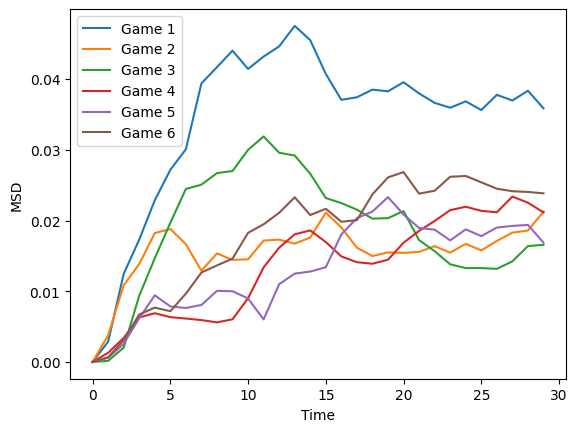

In [13]:
# Measure mean square displacement
from skmob.measures.collective import mean_square_displacement

for i in range(1,7):
    msd_over_time = []
    for t in range(30):
        data_df = pd.read_csv("AllTracks.csv")
        groups = data_df.groupby(["Game"])
        data_df_game = groups.get_group(i)
        tdf = skmob.TrajDataFrame(data_df_game, latitude="Latitude", longitude="Longitude", datetime="Timestamp", user_id="Player_ID", trajectory_id="Trajectory_ID")
        msd = mean_square_displacement(tdf, hours=0, minutes=t, show_progress=False)
        msd_over_time.append(msd)
    plt.plot(range(30), msd_over_time, label=f'Game {i}')
plt.legend()
plt.xlabel('Time')
plt.ylabel('MSD')
plt.show()

In [14]:
from skmob.measures.collective import random_location_entropy
import folium
from folium.plugins import HeatMap

game = 4

data_df = pd.read_csv("AllTracks.csv")
groups = data_df.groupby(["Game"])
data_df_game = groups.get_group(game)
tdf = skmob.TrajDataFrame(data_df_game, latitude="Latitude", longitude="Longitude", datetime="Timestamp", user_id="Player_ID", trajectory_id="Trajectory_ID")
rle = random_location_entropy(tdf, show_progress=False)

m = folium.Map(location=[47.142099, -70.463379], zoom_start=17, control_scale=True)
gradient={0.6:'#ffffff', 0.7:'#d2d6f6', 0.8:'#a2aeeb', 0.9:'#6c89e0', 1:'#0066d5'}
HeatMap(rle[['lat', 'lng']].values, max_zoom=24, gradient=gradient).add_to(m)
m

In [15]:
from skmob.measures.collective import uncorrelated_location_entropy
import folium
from folium.plugins import HeatMap

game = 6

data_df = pd.read_csv("AllTracks.csv")
groups = data_df.groupby(["Game"])
data_df_game = groups.get_group(game)
tdf = skmob.TrajDataFrame(data_df_game, latitude="Latitude", longitude="Longitude", datetime="Timestamp", user_id="Player_ID", trajectory_id="Trajectory_ID")
ule = uncorrelated_location_entropy(tdf, normalize=True, show_progress=False)

m = folium.Map(location=[47.142099, -70.463379], zoom_start=17, control_scale=True)
gradient={0.6:'#ffffff', 0.7:'#d2d6f6', 0.8:'#a2aeeb', 0.9:'#6c89e0', 1:'#0066d5'}
HeatMap(ule[['lat', 'lng']].values, max_zoom=24, gradient=gradient).add_to(m)
m

In [16]:
from skmob.measures.collective import visits_per_location
import folium
from folium.plugins import HeatMap

game = 6

data_df = pd.read_csv("AllTracks.csv")
groups = data_df.groupby(["Game"])
data_df_game = groups.get_group(game)
tdf = skmob.TrajDataFrame(data_df_game, latitude="Latitude", longitude="Longitude", datetime="Timestamp", user_id="Player_ID", trajectory_id="Trajectory_ID")
vl = visits_per_location(tdf)

m = folium.Map(location=[47.142099, -70.463379], zoom_start=17, control_scale=True)
gradient={0.6:'#ffffff', 0.7:'#d2d6f6', 0.8:'#a2aeeb', 0.9:'#6c89e0', 1:'#0066d5'}
HeatMap(vl[['lat', 'lng']].values, max_zoom=24, gradient=gradient).add_to(m)
m

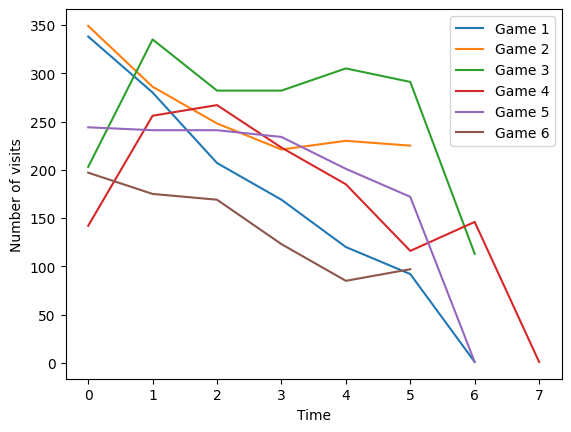

In [17]:
from skmob.measures.collective import visits_per_time_unit

for game in range(1,7):
    data_df = pd.read_csv("AllTracks.csv")
    groups = data_df.groupby(["Game"])
    data_df_game = groups.get_group(game)
    tdf = skmob.TrajDataFrame(data_df_game, latitude="Latitude", longitude="Longitude", datetime="Timestamp", user_id="Player_ID", trajectory_id="Trajectory_ID")
    time_units = '5min'
    vtu = visits_per_time_unit(tdf, time_unit=time_units)
    plt.plot(vtu.values, label=f'Game {game}')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Number of visits')
plt.show()

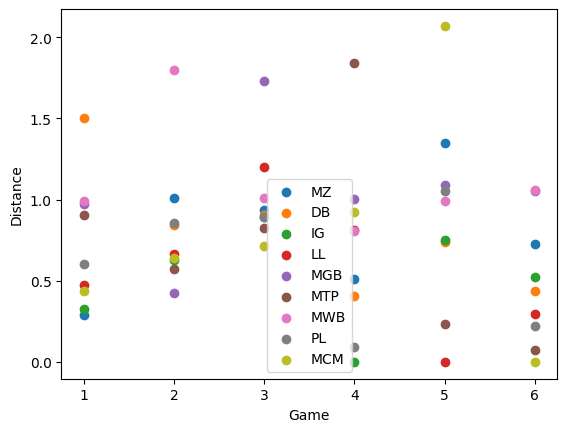

In [18]:
# La distance totale parcourue par chaque joueur.
from skmob.measures.individual import distance_straight_line

user_list = ['MZ', 'DB', 'IG', 'LL', 'MGB', 'MTP', 'MWB', 'PL', 'MCM']
user_dic = {'MZ':[], 'DB':[], 'IG':[], 'LL':[], 'MGB':[], 'MTP':[], 'MWB':[], 'PL':[], 'MCM':[]}
for game in range(1,7):
    data_df = pd.read_csv("AllTracks.csv")
    groups = data_df.groupby(["Game"])
    data_df_game = groups.get_group(game)
    tdf = skmob.TrajDataFrame(data_df_game, latitude="Latitude", longitude="Longitude", datetime="Timestamp", user_id="Player_ID", trajectory_id="Trajectory_ID")
    dsl = distance_straight_line(tdf, show_progress=False)
    for user in user_dic:
        try:
            dsl_of_user = float(dsl.query(f"uid=='{user}'")["distance_straight_line"])
        except:
            dsl_of_user = 0
        user_dic[user].append(dsl_of_user)
for user in user_dic:
    plt.scatter(range(1,7), user_dic[user], label=user)
plt.legend()
plt.xlabel('Game')
plt.ylabel('Distance')
plt.show()

In [16]:
# Frequency rank : On affiche les locations les plus visitées. 
from skmob.measures.individual import frequency_rank

user_list = ['MZ', 'DB', 'IG', 'LL', 'MGB', 'MTP', 'MWB', 'PL', 'MCM']
# color_list = ["#005c25", "#003f5c", "#2f4b7c", "#665191", "#a05195", "#d45087", "#f95d6a", "#ff7c43", "#ffa600"]
color_list = ['blue', 'lightred', 'red', 'purple', 'green', 'orange', 'cadetblue', 'beige', 'pink']
m = folium.Map(location=[47.142099, -70.463379], zoom_start=17, control_scale=True)
game = 2

data_df = pd.read_csv("../data/2022_05/real_positions.csv")
groups = data_df.groupby(["Game"])
data_df_game = groups.get_group(game)
tdf = skmob.TrajDataFrame(data_df_game, latitude="Latitude", longitude="Longitude", datetime="Timestamp", user_id="Player_ID", trajectory_id="Trajectory_ID")
fr_df = frequency_rank(tdf, show_progress=False)

for user, color in zip(user_list, color_list):
    for i in range(2, 6):  # Le premier rank est toujours au début, c'est lame.
        user_fr = fr_df.query(f"uid=='{user}'")
        rank_user_fr = user_fr.query(f"frequency_rank=={i}")
        loc = (rank_user_fr['lat'], rank_user_fr['lng'])
        folium.Marker(location=loc, popup=f'{user}, {i}', icon=folium.Icon(color=color)).add_to(m)
        

        
# tdf.plot_trajectory(map_f=m, max_users=9)        
# Aouter les positions des refuges pour comparer les favorite locations

# Notes : les 7 premières favorite locations de l'apex de la game 1, DB, sont toutes à la même place. Est-ce qu'il tournait autour de ce point-là pour chasser? Maybe c'est un point en altitude?

m


In [18]:
from skmob.measures.individual import location_frequency

game = 1
user = 'DB'

data_df = pd.read_csv("../data/2022_05/real_positions.csv")
groups = data_df.groupby(["Game"])
data_df_game = groups.get_group(game)
tdf = skmob.TrajDataFrame(data_df_game, latitude="Latitude", longitude="Longitude", datetime="Timestamp", user_id="Player_ID", trajectory_id="Trajectory_ID")
lf_df = location_frequency(tdf, show_progress=False)
lf_groups = lf_df.groupby('uid')
lf_df_user = lf_groups.get_group(user)

tdf
# m = folium.Map(location=[47.142099, -70.463379], zoom_start=17, control_scale=True)
# gradient={0.6:'#ffffff', 0.7:'#d2d6f6', 0.8:'#a2aeeb', 0.9:'#6c89e0', 1:'#0066d5'}
# HeatMap(lf_df_user[['lat', 'lng']].values, max_zoom=24, gradient=gradient).add_to(m)
# m

,Unnamed: 0,Elevation,lat,lng,datetime,Game,uid
0,41,13.60,47.142318,-70.463430,2022-05-10 16:40:06,1,MZ
1,42,14.08,47.142348,-70.463413,2022-05-10 16:40:10,1,MZ
2,43,13.60,47.142382,-70.463429,2022-05-10 16:40:13,1,MZ
3,44,13.60,47.142430,-70.463443,2022-05-10 16:40:19,1,MZ
4,45,14.08,47.142478,-70.463475,2022-05-10 16:40:26,1,MZ
...,...,...,...,...,...,...,...
6870,6891,6.87,47.142681,-70.464675,2022-05-10 17:04:19,1,MGB
6871,6901,8.79,47.142679,-70.464629,2022-05-10 17:04:26,1,MGB
6872,6911,9.27,47.142707,-70.464574,2022-05-10 17:04:32,1,MGB
6873,6921,9.75,47.142747,-70.464339,2022-05-10 17:04:45,1,MGB


# Uniformiser le time window du dataset

In [19]:
from shapely import LineString

def points_on_line(lat1, lon1, lat2, lon2, num_points):
    line = LineString([[lat1, lon1], [lat2, lon2]])
    new_points = [line.interpolate(i/float(num_points - 1), normalized=True) for i in range(num_points)]
    for i, point in enumerate(new_points):
        new_points[i] = [point.x, point.y]
    return new_points

In [20]:
# Written by ChatGPT
def points_on_arc(lat1, lon1, lat2, lon2, num_points):
    # Convert latitudes and longitudes to radians
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    # Compute the distance between the two points using the Haversine formula
    d = 2 * np.arcsin(np.sqrt(np.sin((lat2 - lat1) / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2 - lon1) / 2)**2))
    
    # Compute the step size between points
    step = d / (num_points - 1)

    # Compute the array of points on the arc
    points = []
    for i in range(num_points):
        # Compute the intermediate point on the great circle arc
        f = float(i) / float(num_points - 1)
        A = np.sin((1 - f) * d) / np.sin(d)
        B = np.sin(f * d) / np.sin(d)
        x = A * np.cos(lat1) * np.cos(lon1) + B * np.cos(lat2) * np.cos(lon2)
        y = A * np.cos(lat1) * np.sin(lon1) + B * np.cos(lat2) * np.sin(lon2)
        z = A * np.sin(lat1) + B * np.sin(lat2)
        lat = np.arctan2(z, np.sqrt(x**2 + y**2))
        lon = np.arctan2(y, x)
        
        # Append the point to the list
        points.append(np.degrees([lat, lon]))
#         points.append(tuple(np.degrees([lat, lon])))

    return points


def points_on_line(lat1, lon1, lat2, lon2, num_points):
    # Convert points to numpy arrays
    point1 = (lat1, lon1)
    point2 = (lat2, lon2)
    p1 = np.array(point1)
    p2 = np.array(point2)
    
    # Compute the vector from point1 to point2
    vec = p2 - p1
    
    # Compute the step size between points
    step = vec / (num_points - 1)
    
    # Compute the array of points on the line
    points = [p1 + i*step for i in range(num_points)]
    
    return points

In [22]:
data_df = pd.read_csv("../data/2022_05/real_positions.csv")
players_df = pd.read_csv("../data/2022_05/Player_data.csv", sep=';')

data_groups = data_df.groupby(["Game", "Player_ID"])
player_groups = players_df.groupby(["Game"])

uniformized_array = []

for game in range(1,7):
    game_df = player_groups.get_group(game)
    users = game_df['Player_ID'].values
    for user in users:
        df = data_groups.get_group((game, user)).copy()
        df.Timestamp = pd.to_datetime(df.Timestamp)
        array = df.to_numpy()
        start_line = array[0]
        time = start_line[4]
        one_second = np.timedelta64(1, 's')
        for line in array[1:-1]:
            timedelta = np.timedelta64(line[4] - start_line[4], 's')
            if timedelta > 1:
                lat1, lon1 = start_line[2], start_line[3]
                lat2, lon2 = line[2], line[3]
                coordinates = points_on_arc(lat1, lon1, lat2, lon2, timedelta.astype(int)+1)
                for coordinate in coordinates[:-1]:
                    uniformized_line = np.array([coordinate[0], coordinate[1], time, game, user])
                    time += one_second
                    uniformized_array.append(uniformized_line)
            start_line = line
        # Treat the last line differently to include the before last point
        end_line = array[-1]
        timedelta = np.timedelta64(end_line[4] - line[4], 's')
        if timedelta > 1:
            lat1, lon1 = line[2], line[3]
            lat2, lon2 = end_line[2], end_line[3]
            coordinates = points_on_arc(lat1, lon1, lat2, lon2, timedelta.astype(int)+1)
            for coordinate in coordinates:
                uniformized_line = np.array([coordinate[0], coordinate[1], time, game, user])
                time += one_second
                uniformized_array.append(uniformized_line)
        # Add the last point
        uniformized_line = np.array([end_line[2], end_line[3], time, game, user])
        uniformized_array.append(uniformized_line)

uniformized_df = pd.DataFrame(uniformized_array, columns = ['lat','lng', 'datetime', 'Game', 'uid'])
uniformized_df.to_csv('UniformizedAllTracks.csv', index=False)

In [24]:
# Compare the trajectories of the original dataset vs the uniform dataset

game = 1

player_df = pd.read_csv("../data/2022_05/Player_data.csv", sep=';')

original_data_df = pd.read_csv("../data/2022_05/real_positions.csv")
original_groups = original_data_df.groupby(["Game"])
original_data_df_game = original_groups.get_group(game)
original_tdf = skmob.TrajDataFrame(original_data_df_game, latitude="Latitude", longitude="Longitude", datetime="Timestamp", user_id="Player_ID", trajectory_id="Trajectory_ID")

uniform_data_df = pd.read_csv("UniformizedAllTracks.csv")
uniform_groups = uniform_data_df.groupby(["Game"])
uniform_data_df_game = uniform_groups.get_group(game)
uniform_tdf = skmob.TrajDataFrame(uniform_data_df_game)
player_groups = uniform_tdf.groupby("uid")
player_tdf = player_groups.get_group("DB")
# print(uniform_tdf)

map_f = folium.Map(location=[47.142099, -70.463379], zoom_start=18, max_zoom=30, control_scale=True)

original_tdf.plot_trajectory(map_f=map_f, max_users = 1, max_points=None, start_end_markers=False)
uniform_tdf.plot_trajectory(map_f=map_f, max_users = 1, max_points=None, start_end_markers=False)

for line in player_tdf.to_numpy()[:198]:
    folium.Marker(location=(line[0], line[1]), popup=f'{array[-1]}', icon=folium.Icon()).add_to(map_f)

map_f

# OLD stuff

# Constructing a contact dataset

In [26]:
def create_user_int_dict(user_df, game):
    game_groups = user_df.groupby(["Game"])
    game_user_df = game_groups.get_group(game)
    user_int_dict = dict.fromkeys(game_user_df.Player_ID.values, 0)
    for i, user in enumerate(user_int_dict):
        user_int_dict[user] = i
    return user_int_dict


def make_contacts_dataset_csv(game, distance_treshold):
    contacts = []
    
    user_df = pd.read_csv("player_data.csv", sep=';')
    user_int_dict = create_user_int_dict(user_df, game)

    data_df = pd.read_csv("UniformizedAllTracks.csv")
    groups = data_df.groupby(["Game"])
    data_df_game = groups.get_group(game).copy()
    data_df_game.datetime = pd.to_datetime(data_df_game.datetime)
    data_df_game = data_df_game.sort_values('datetime')

    start_time = data_df_game.datetime.values[0]
    end_time = data_df_game.datetime.values[-1]
    one_second = np.timedelta64(1,'s')
    time = start_time

    while time != end_time:
        time_groups = data_df_game.groupby(['datetime'])
        df_datetime = time_groups.get_group(time)

        array = df_datetime.to_numpy()
        for i in range(len(array)):
            for j in range(i+1, len(array)):
                coord1 = (array[i][0], array[i][1])
                coord2 = (array [j][0], array[j][1])
                distance = geopy.distance.geodesic(coord1, coord2).m  # .m means that the distance is in meters.
                if distance < distance_treshold:
                    deltatime = np.timedelta64((time - start_time), 's').astype(int)
                    user1 = array[i][4]
                    user2 = array[j][4]
                    contacts.append([deltatime, user1, user2])
        time += one_second

    contacts_df = pd.DataFrame(contacts, columns = ['time', 'source', 'target'])
    contacts_df.to_csv(f'ContactsDatasets/contacts_game{game}_{distance_treshold}m.csv', index=False)
    print(f'Game {game}, {distance_treshold}m done.')

In [28]:
for game in range(1,7):
    for distance in range(5, 61, 5):
        make_contacts_dataset_csv(game, distance)

Game 1, 5m done.
Game 1, 10m done.
Game 1, 15m done.
Game 1, 20m done.
Game 1, 25m done.
Game 1, 30m done.
Game 1, 35m done.
Game 1, 40m done.
Game 1, 45m done.
Game 1, 50m done.
Game 1, 55m done.
Game 1, 60m done.
Game 2, 5m done.
Game 2, 10m done.
Game 2, 15m done.
Game 2, 20m done.
Game 2, 25m done.
Game 2, 30m done.
Game 2, 35m done.
Game 2, 40m done.
Game 2, 45m done.
Game 2, 50m done.
Game 2, 55m done.
Game 2, 60m done.
Game 3, 5m done.
Game 3, 10m done.
Game 3, 15m done.
Game 3, 20m done.
Game 3, 25m done.
Game 3, 30m done.
Game 3, 35m done.
Game 3, 40m done.
Game 3, 45m done.
Game 3, 50m done.
Game 3, 55m done.
Game 3, 60m done.
Game 4, 5m done.
Game 4, 10m done.
Game 4, 15m done.
Game 4, 20m done.
Game 4, 25m done.
Game 4, 30m done.
Game 4, 35m done.
Game 4, 40m done.
Game 4, 45m done.
Game 4, 50m done.
Game 4, 55m done.
Game 4, 60m done.
Game 5, 5m done.
Game 5, 10m done.
Game 5, 15m done.
Game 5, 20m done.
Game 5, 25m done.
Game 5, 30m done.
Game 5, 35m done.
Game 5, 40m don

In [258]:
def create_player_int_dict(player_df, game):
    game_groups = player_df.groupby(["Game"])
    game_player_df = game_groups.get_group(game)
    player_int_dict = dict.fromkeys(game_player_df.Player_ID.values, 0)
    for i, player in enumerate(player_int_dict):
        player_int_dict[player] = i
    return player_int_dict

game = 1
player_df = pd.read_csv("Player_data.csv", sep=';')
player_int_dict = create_player_int_dict(player_df, game)
print(player_int_dict)

{'MZ': 0, 'MTP': 1, 'PL': 2, 'MCM': 3, 'MWB': 4, 'MGB': 5, 'IG': 6, 'LL': 7, 'DB': 8}


In [272]:
data_df = pd.read_csv("UniformizedAllTracks.csv")
groups = data_df.groupby(["Game"])
data_df_game = groups.get_group(1)
tdf = skmob.TrajDataFrame(data_df_game, latitude="Latitude", longitude="Longitude", datetime="Timestamp", user_id="Player_ID", trajectory_id="Trajectory_ID")
tdf

,Unnamed: 0,lat,lng,datetime,Game,uid
0,0,47.142318,-70.463430,2022-05-10 16:40:06,1,MZ
1,1,47.142328,-70.463425,2022-05-10 16:40:07,1,MZ
2,2,47.142338,-70.463419,2022-05-10 16:40:08,1,MZ
3,3,47.142348,-70.463413,2022-05-10 16:40:09,1,MZ
4,4,47.142365,-70.463421,2022-05-10 16:40:10,1,MZ
...,...,...,...,...,...,...
9626,9626,47.143614,-70.464674,2022-05-10 17:06:39,1,DB
9627,9627,47.143606,-70.464668,2022-05-10 17:06:40,1,DB
9628,9628,47.143599,-70.464661,2022-05-10 17:06:41,1,DB
9629,9629,47.143591,-70.464655,2022-05-10 17:06:42,1,DB


In [265]:
array = tdf.to_numpy()

game = 1
player_df = pd.read_csv("Player_data.csv", sep=';')
player_int_dict = create_player_int_dict(player_df, game)

contacts = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
contacts = []

# for i in array:
i = 43
line1 = array[i]
coord_1 = (line1[1], line1[2])
time_1 = line1[3]
for j in range(i, len(array)):
    line2 = array[j]
    coord_2 = (line2[1], line2[2])
    time_2 = line2[3]
    distance = geopy.distance.geodesic(coord_1, coord_2).m
    timedelta = np.timedelta64(time_1 - time_2, 's')
    if distance < 5 and np.abs(timedelta) < 5 and line1[5]!=line2[5]:
        contacts.append(line2)

print(line1)
print(contacts)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
[43 47.14278006926181 -70.4634626861662 Timestamp('2022-05-10 16:40:49') 1
 'MZ']
[array([3928, 47.14274849742652, -70.4634758550648,
       Timestamp('2022-05-10 16:40:45'), 1, 'MWB'], dtype=object), array([3929, 47.14276235550641, -70.46347656287107,
       Timestamp('2022-05-10 16:40:46'), 1, 'MWB'], dtype=object), array([3930, 47.1427762135863, -70.4634772706777,
       Timestamp('2022-05-10 16:40:47'), 1, 'MWB'], dtype=object), array([3931, 47.14278426021713, -70.46349044422554,
       Timestamp('2022-05-10 16:40:48'), 1, 'MWB'], dtype=object), array([3932, 47.142792306846445, -70.46350361777738,
       Timestamp('2022-05-10 16:40:49'), 1, 'MWB'], dtype=object), array([3933, 47.14280035347426, -70.4635167913332,
       Timestamp('2022-05-10 16:40:50'), 1, 'MWB'], dtype=object), array([6877, 47.1427365671843, -70.4634474311024,
       Timestamp('2022-05-10 16:40:49'), 1, 'IG'], dtype=object), array([6878, 47.142747337930736, -70.46

In [24]:
contacts = np.zeros((len(array), len(array)))
print(contacts)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [81]:
times = tdf.datetime.values
time_0 = times[0]
time_1 = times[1]
delta = time_0 - time_1
timedelta = np.timedelta64(delta, 's')
print(timedelta > 8)

False


In [6]:
coords_1 = (47.142593, -70.464139)
coords_2 = (47.142661, -70.464123)

print(geopy.distance.geodesic(coords_1, coords_2).m)

7.656606829010262


In [100]:
# IDÉE : il faut tesseller l'espace et diviser les points (chaque entrées de GPS) selon les différentes régions obtenues.
# Ensuite, on peut séparer les points selon leur région (et leurs régions voisines), et il reste juste à comparer les points
# ces groupes-là. Ainsi, pour voir s'il y a un contact, on a pas besoin de faire len(tdf)**2 comparaisons, ce qui sauve beaucoup
# de computing time.
# Problème : il faut trouver un moyen de tesseller (en carrés) pour que ce soit facile d'itérer sur chaque carrés selon leur ID.
# En ce moment j'ai un tessellation en carrés, mais c'est pas clair comment les carrés sont indicés. 
# Ça va de bas en haut, gauche vers droite, mais dépendamment des longueurs qu'on donne, 
# il est possible que certaines rangées ou lignes soient tronquées, c'est-à-dire que nombre de carrés
# final est pas un carré parfait et que c'est pas clair comment on peut itérer sur chaque carré et ses voisins.


# Workaround pour tesseller à partir du CRS
tessellation = tilers.tiler.get("squared", base_shape="Saint-Antoine-de-l'Isle-aux-Grues, Québec, Canada", meters=1100)
groups = tessellation.groupby(["tile_ID"])
tessellation = groups.get_group('400')

length=50
tessellation = tilers.tiler.get("squared", base_shape=tessellation, meters=length*np.sqrt(2))
print(tessellation)

fdf = tdf.to_flowdataframe(tessellation=tessellation, self_loops=True)
m = fdf.plot_tessellation()
m

C:\Users\frank\OneDrive\Documents\Uni\Doctorat\Python\TemporalMobility\lib\site-packages\skmob\tessellation\tilers.py:117: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  base_shape = gpd.GeoSeries(cascaded_union(polygons), crs=base_shape.crs)
C:\Users\frank\OneDrive\Documents\Uni\Doctorat\Python\TemporalMobility\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\frank\AppData\Local\Temp\ipykernel_23496\3961242086.py:15: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  fdf = tdf.to_flowdataframe(tessellation=tessellation, self

    tile_ID                                           geometry
0         0  POLYGON ((-70.47080 47.14038, -70.47080 47.140...
1         1  POLYGON ((-70.47080 47.14081, -70.47080 47.141...
2         2  POLYGON ((-70.47080 47.14124, -70.47080 47.141...
3         3  POLYGON ((-70.47080 47.14167, -70.47080 47.142...
4         4  POLYGON ((-70.47080 47.14210, -70.47080 47.142...
..      ...                                                ...
251     251  POLYGON ((-70.46128 47.14513, -70.46128 47.145...
252     252  POLYGON ((-70.46128 47.14556, -70.46128 47.145...
253     253  POLYGON ((-70.46128 47.14599, -70.46128 47.146...
254     254  POLYGON ((-70.46128 47.14642, -70.46128 47.146...
255     255  POLYGON ((-70.46128 47.14686, -70.46128 47.147...

[256 rows x 2 columns]


In [ ]:
tile_ID = 323

number_of_squares_per_line = base_length / square_length

3.0


In [ ]:
dic = {'a':[], 'b':[]}
print(dic)
dic['a'].append('oui')
print(dic)

# for value in dsl.values:
#     print(value[0])
#     print(value[1])

In [82]:
# Tentative de spécifier moi-même la région à tesseller
max_values = tdf.max()
min_values = tdf.min()
max_lat = max_values["lat"]
max_lng = max_values["lng"]
min_lat = min_values["lat"]
min_lng = min_values["lng"]

base_shape = {'tile_ID' : [0], 'geometry' : [f"POLYGON (({min_lat}, {min_lng}), ({max_lat}, {min_lng}), ({min_lat}, {max_lng}), ({max_lat}, {min_lng}))"]}
base_shape = gpd.GeoDataFrame(base_shape)
print(base_shape)

tessellation = tilers.tiler.get("squared", base_shape=base_shape, meters=50)
print(tessellation)
# groups = tessellation.groupby(["tile_ID"])
# tessellation = groups.get_group('472')
# print(tessellation)

   tile_ID                                           geometry
0        0  POLYGON ((47.1421936713159, -70.4657915979624)...


AttributeError: 'Series' object has no attribute 'to_crs'

In [ ]:
m = fdf.plot_tessellation(zoom=15)
m

In [143]:
df = pd.DataFrame({
    'date': ['2022-01-01', '2022-01-01', '2022-01-02', '2022-01-02'],
    'value1': [1, 2, 3, 4],
    'value2': [5, 6, 7, 8]
})
df['date'] = pd.to_datetime(df['date'])

grouped_df = df.groupby('date').sum()

print(grouped_df)

            value1  value2
date                      
2022-01-01       3      11
2022-01-02       7      15
